<a href="https://colab.research.google.com/github/gtnothaft/Steane_pauli_error/blob/main/Steane_code_pauli_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install qiskit qiskit_aer pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=1a338d6bf6016824ae550a261907c3ac09a7b3aefa16722b06ddc1fc73ecf4e2
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


the logical qubits were defined on sloanes paper: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.77.793

This next cell validates the $|0_L\rangle$ and $|1_L\rangle$ states from the parity-check matrix

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# 1. Define the parity-check matrix H (based on Nielsen & Chuang section 10.4.2)


def matrix():
  H = np.array([
    [0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 1]
  ])
  return H

def zero_state():
  H=matrix()


  dual_codewords = []
  for coeffs in np.ndindex(*([2]*3)):  # All 3-bit combinations
    codeword = np.mod(np.dot(coeffs, H), 2)
    dual_codewords.append(''.join(map(str, codeword)))

  zero_L = np.zeros(2**7)
  for c in dual_codewords:
    zero_L[int(c, 2)] = 1/np.sqrt(8)

  qc = QuantumCircuit(7)
  qc.initialize(Statevector(zero_L), range(7))
  return qc

def one_state():
    H = matrix()
    one_L = np.zeros(2**7)

    for coeffs in np.ndindex(*([2]*3)):  # All 3-bit combinations
        codeword = np.mod(np.dot(coeffs, H), 2)
        flipped_codeword = ''.join(['1' if b == 0 else '0' for b in codeword])
        one_L[int(flipped_codeword, 2)] = 1 / np.sqrt(8)

    steane = QuantumRegister(7, "Steane")
    qc = QuantumCircuit(steane)
    qc.initialize(Statevector(one_L), steane)
    return qc, steane


qc = zero_state()

sv = Statevector(qc)
print("Logical |0_L⟩ state (non-zero amplitudes):")
for i, amp in enumerate(sv):
    if not np.isclose(amp, 0):
        print(f"|{format(i, '07b')}⟩ : {amp:.4f}")

qc,_ = one_state()

sv = Statevector(qc)
print("Logical |1_L⟩ state (non-zero amplitudes):")
for i, amp in enumerate(sv):
    if not np.isclose(amp, 0):
        print(f"|{format(i, '07b')}⟩ : {amp:.4f}")



Logical |0_L⟩ state (non-zero amplitudes):
|0000000⟩ : 0.3536+0.0000j
|0001111⟩ : 0.3536+0.0000j
|0110011⟩ : 0.3536+0.0000j
|0111100⟩ : 0.3536+0.0000j
|1010101⟩ : 0.3536+0.0000j
|1011010⟩ : 0.3536+0.0000j
|1100110⟩ : 0.3536+0.0000j
|1101001⟩ : 0.3536+0.0000j
Logical |1_L⟩ state (non-zero amplitudes):
|0010110⟩ : 0.3536+0.0000j
|0011001⟩ : 0.3536+0.0000j
|0100101⟩ : 0.3536+0.0000j
|0101010⟩ : 0.3536+0.0000j
|1000011⟩ : 0.3536+0.0000j
|1001100⟩ : 0.3536+0.0000j
|1110000⟩ : 0.3536+0.0000j
|1111111⟩ : 0.3536+0.0000j


This next cell sets up the main functions and outputs the quantum circuit from it.

|0_L⟩:


<IPython.core.display.Latex object>

|1_L⟩:


<IPython.core.display.Latex object>

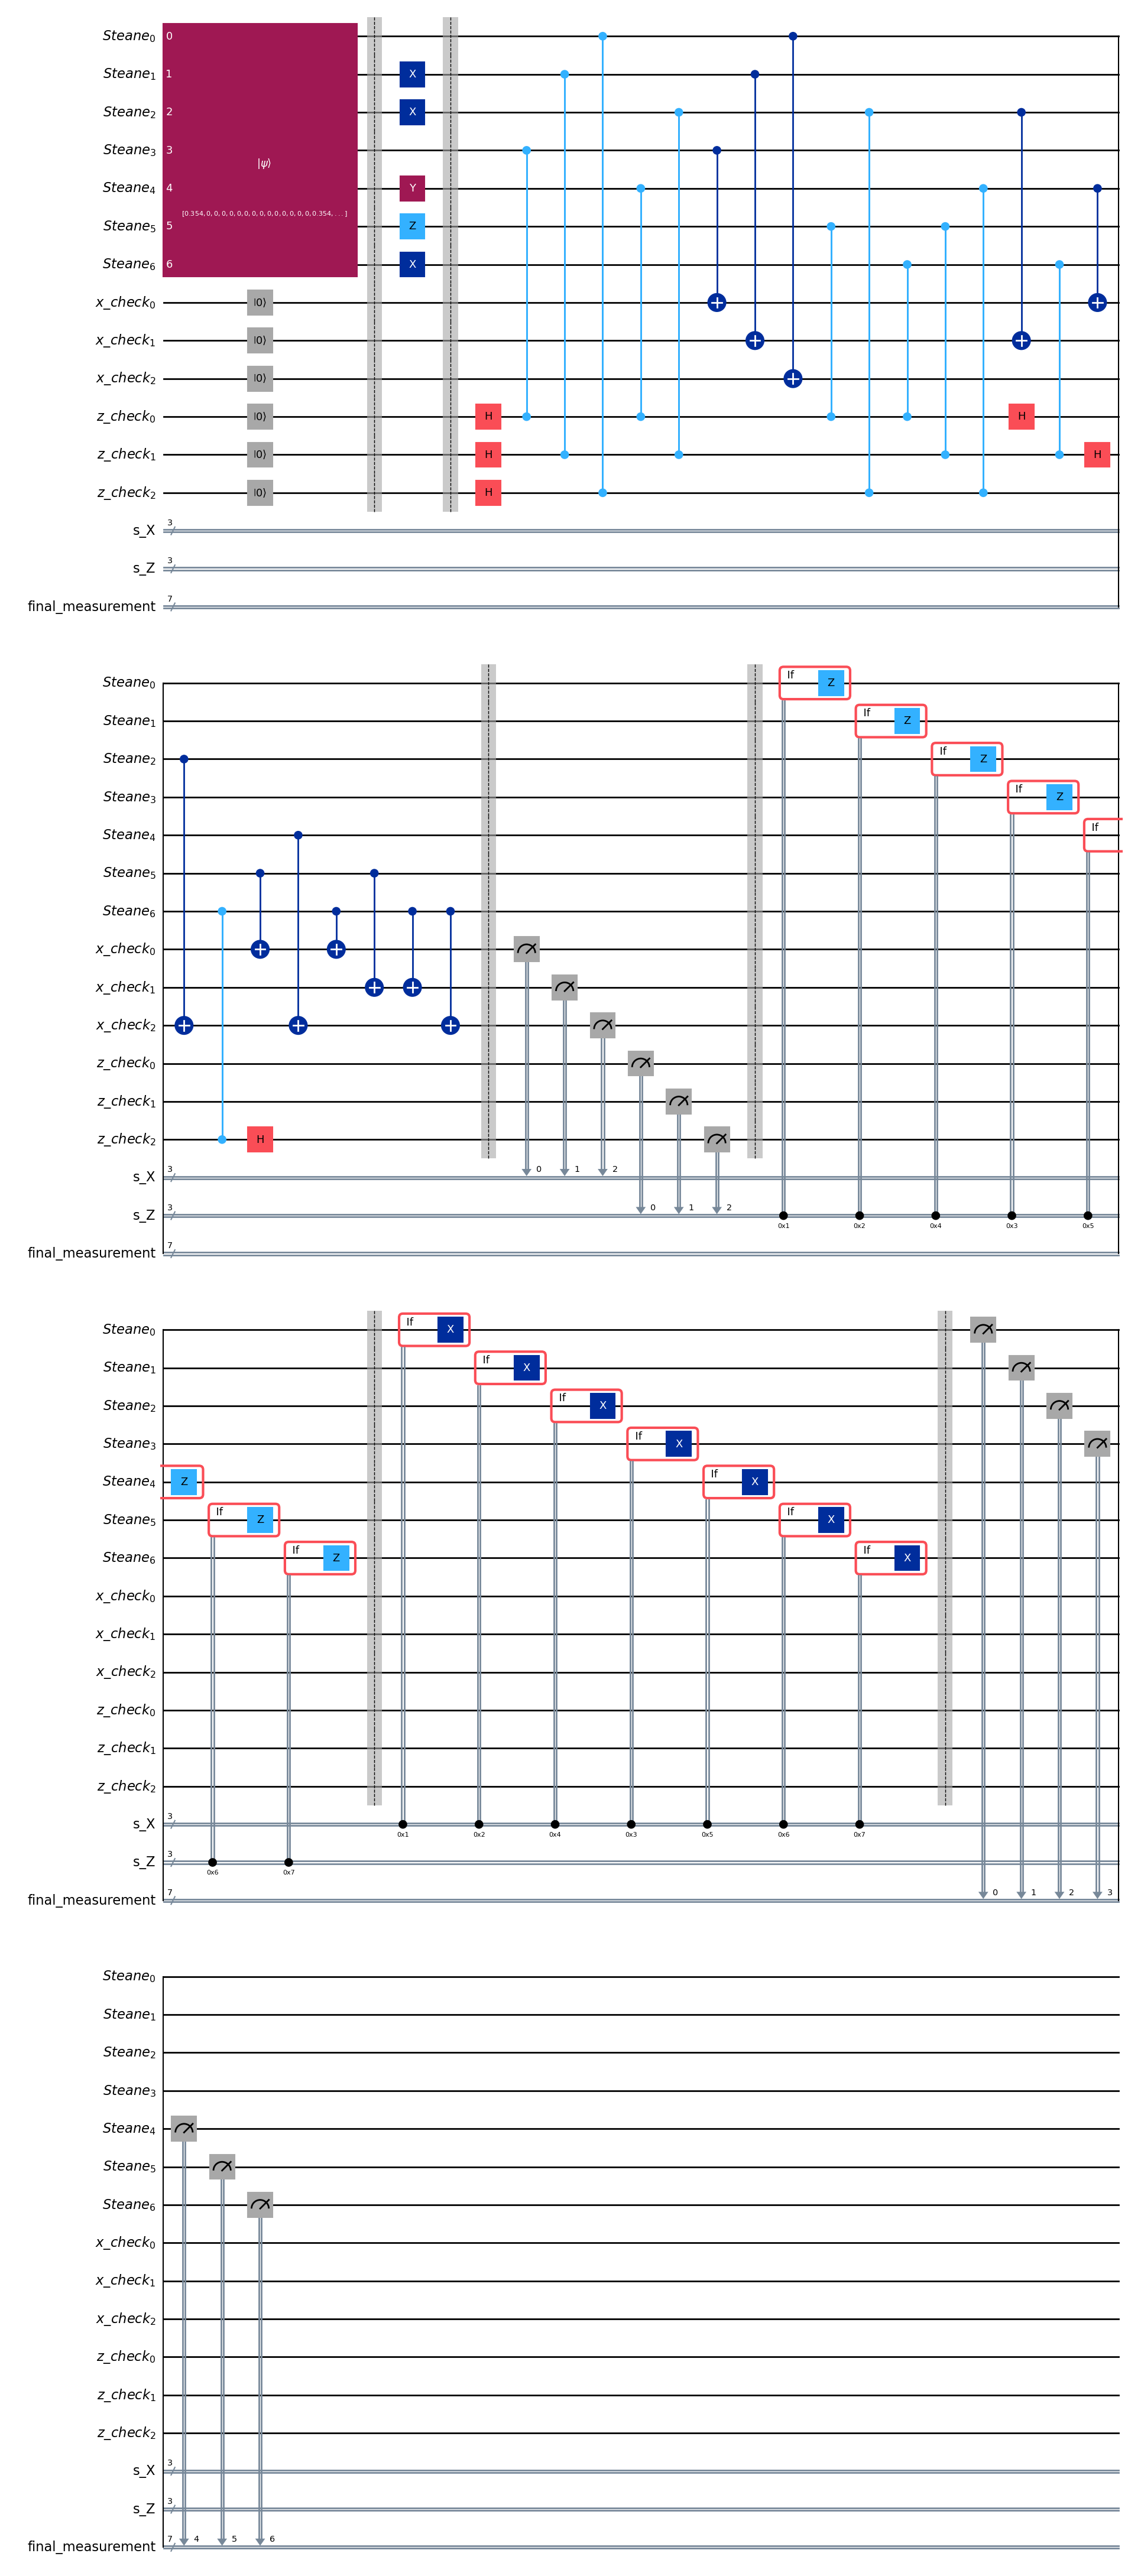

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit import transpile

def matrix():
  H = np.array([
    [0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 0, 0, 1, 1],
    [1, 0, 1, 0, 1, 0, 1]
  ])
  return H

def zero_state():
  H=matrix()

  dual_codewords = []
  for coeffs in np.ndindex(*([2]*3)):  # All 3-bit combinations
    codeword = np.mod(np.dot(coeffs, H), 2)
    dual_codewords.append(''.join(map(str, codeword)))

  zero_L = np.zeros(2**7)
  for c in dual_codewords:
    zero_L[int(c, 2)] = 1 / np.sqrt(8)

  steane=QuantumRegister(7, "Steane")
  qc = QuantumCircuit(steane)
  qc.initialize(Statevector(zero_L), range(7))
  return qc, steane

def one_state():
    H = matrix()
    one_L = np.zeros(2**7)

    for coeffs in np.ndindex(*([2]*3)):  # All 3-bit combinations
        codeword = np.mod(np.dot(coeffs, H), 2)
        flipped_codeword = ''.join(['1' if b == 0 else '0' for b in codeword])
        one_L[int(flipped_codeword, 2)] = 1 / np.sqrt(8)

    steane = QuantumRegister(7, "Steane")
    qc = QuantumCircuit(steane)
    qc.initialize(Statevector(one_L), steane)
    return qc, steane

def prepare_logical_state(x: int):
    if x==0:
      qc,steane = zero_state()
    else:
      qc,steane = one_state()
    return qc,steane

def apply_error(qc, qubits, p_total):
    p = p_total/3
    for qubit in qubits:
          r = np.random.random()
          if r < p:
            qc.x(qubit)
          elif r < 2*p:
            qc.y(qubit)
          elif r < 3*p:
            qc.z(qubit)
    return qc

def pauli_error_channel(x,p):
  qc, steane = prepare_logical_state(x)
  x_check = AncillaRegister(3, "x_check")
  z_check = AncillaRegister(3, "z_check")
  X_syndromes = ClassicalRegister(3, "s_X")
  Z_syndromes = ClassicalRegister(3, "s_Z")
  qubit_measurements = ClassicalRegister(7, "final_measurement")

  qc.add_register(x_check, z_check, X_syndromes, Z_syndromes, qubit_measurements)
  qc.reset(x_check)
  qc.reset(z_check)
  qc.barrier()
  apply_error(qc, steane, p)
  qc.barrier()

  for idx, row in enumerate(matrix()):
    qc.h(z_check[idx])
    for qubit in np.where(row)[0]:
        qc.cz(z_check[idx],qubit)
    qc.h(z_check[idx])

  for idx,row in enumerate(matrix()):
    for qubit in np.where(row)[0]:
      qc.cx(qubit,x_check[idx])

  qc.barrier()
  qc.measure(x_check, X_syndromes)
  qc.measure(z_check, Z_syndromes)

  qc.barrier()
  qcf, steane = corrected_checks(qc, X_syndromes, Z_syndromes, steane)

  qcf.measure(steane, qubit_measurements)
  return qcf

from qiskit.circuit import IfElseOp


def corrected_checks(qc, X_syndromes, Z_syndromes, steane):
    """Corrected version using proper Steane code syndrome mapping"""
    with qc.if_test((Z_syndromes, 0b001)):
        qc.z(steane[0])  # Z1
    with qc.if_test((Z_syndromes, 0b010)):
        qc.z(steane[1])  # Z2
    with qc.if_test((Z_syndromes, 0b100)):
        qc.z(steane[2])  # Z3
    with qc.if_test((Z_syndromes, 0b011)):
        qc.z(steane[3])  # Z4
    with qc.if_test((Z_syndromes, 0b101)):
        qc.z(steane[4])  # Z5
    with qc.if_test((Z_syndromes, 0b110)):
        qc.z(steane[5])  # Z6
    with qc.if_test((Z_syndromes, 0b111)):
        qc.z(steane[6])  # Z7
    qc.barrier()

    with qc.if_test((X_syndromes, 0b001)):
        qc.x(steane[0])  # X1
    with qc.if_test((X_syndromes, 0b010)):
        qc.x(steane[1])  # X2
    with qc.if_test((X_syndromes, 0b100)):
        qc.x(steane[2])  # X3
    with qc.if_test((X_syndromes, 0b011)):
        qc.x(steane[3])  # X4
    with qc.if_test((X_syndromes, 0b101)):
        qc.x(steane[4])  # X5
    with qc.if_test((X_syndromes, 0b110)):
        qc.x(steane[5])  # X6
    with qc.if_test((X_syndromes, 0b111)):
        qc.x(steane[6])  # X7
    qc.barrier()
    return qc, steane



q1,trash= prepare_logical_state(1)
q0,trash2 = prepare_logical_state(0)
print("|0_L⟩:")
display(Statevector(q0).draw('latex'))

print("|1_L⟩:")
display(Statevector(q1).draw('latex'))


p=0.4
x=0
qcf = pauli_error_channel(x,p)


qcf.draw(output="mpl")


This next piece of code outputs the result of the simulation for any value of p. Currently we have $p=0$ to test that it prints out the $|0_L\rangle$ state

In [ ]:
p=0.0
x=0
qc1 = pauli_error_channel(x,p)
simulator = AerSimulator()

rounds = 1000
# Transpile the circuit for the backend
compiled_circuit = transpile(qc1, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=rounds)

# Get the measurement counts
counts = job.result().get_counts()

distribution = {}
for measurement in counts:
    if measurement[:7] in distribution:
        distribution[measurement[:7]] += counts[measurement] / rounds
    else:
        distribution[measurement[:7]] = counts[measurement] / rounds

distribution

{'1011010': 0.133,
 '0111100': 0.132,
 '1101001': 0.103,
 '1010101': 0.131,
 '0110011': 0.138,
 '1100110': 0.11,
 '0000000': 0.128,
 '0001111': 0.125}

Here, I am calculating the success rate of measuring any of the $|0_L\rangle$ state for p values between 0 and 0.5. The plot shows the general trend, where the success rate start at 1 if $p=0$ and goes down from there.

p = 0.00, Success rate = 1.000
p = 0.01, Success rate = 0.980
p = 0.01, Success rate = 0.970
p = 0.02, Success rate = 0.900
p = 0.02, Success rate = 0.890
p = 0.03, Success rate = 0.930
p = 0.03, Success rate = 0.830
p = 0.04, Success rate = 0.830
p = 0.04, Success rate = 0.900
p = 0.05, Success rate = 0.850
p = 0.05, Success rate = 0.780
p = 0.06, Success rate = 0.800
p = 0.06, Success rate = 0.820
p = 0.07, Success rate = 0.700
p = 0.07, Success rate = 0.720
p = 0.08, Success rate = 0.690
p = 0.08, Success rate = 0.720
p = 0.09, Success rate = 0.680
p = 0.09, Success rate = 0.700
p = 0.10, Success rate = 0.630
p = 0.10, Success rate = 0.590
p = 0.11, Success rate = 0.590
p = 0.11, Success rate = 0.590
p = 0.12, Success rate = 0.680
p = 0.12, Success rate = 0.620
p = 0.13, Success rate = 0.560
p = 0.13, Success rate = 0.480
p = 0.14, Success rate = 0.550
p = 0.14, Success rate = 0.560
p = 0.15, Success rate = 0.450
p = 0.15, Success rate = 0.390
p = 0.16, Success rate = 0.410
p = 0.16

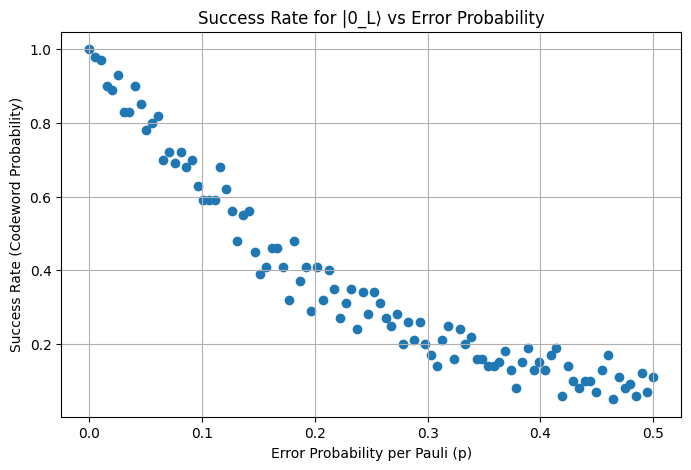

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Define all valid |0_L⟩ codewords for Steane code
zero_codewords = {
    '0000000', '0001111', '0110011', '0111100',
    '1010101', '1011010', '1100110', '1101001'
}
one_codewords = {
    '1111111', '1110000', '1001100', '1000011',
    '0101010', '0100101', '0011001', '0010110'
}

def simulate_error_correction(x,p, shots=20):
    result ={}
    simulator= AerSimulator()
    for _ in range(shots):
        qcf = pauli_error_channel(x,p)


        # Simulate
        compiled_circuit = transpile(qcf, simulator)
        job = simulator.run(compiled_circuit, shots=1)
        counts = job.result().get_counts()
        for outcome, count in counts.items():
            data_qubits = outcome[:7]  # First 7 bits are data qubits
            result[data_qubits] = result.get(data_qubits, 0) + counts[outcome]
        #print(data_qubits)
    distribution = {key: count / shots for key, count in result.items()}
    return distribution

def study_probabilities(x, p_values, shots=100):
    """Study how success rate changes with different error probabilities."""
    codewords = zero_codewords if x == 0 else one_codewords
    success_rates = []

    for p in p_values:
        distribution = simulate_error_correction(x, p, shots)
        success_rate = sum(distribution.get(state, 0.0) for state in codewords)
        success_rates.append(success_rate)
        print(f"p = {p:.2f}, Success rate = {success_rate:.3f}")
        #print("Observed states:", distribution)

    plt.figure(figsize=(8, 5))
    plt.scatter(p_values, success_rates, marker='o')
    plt.xlabel('Error Probability per Pauli (p)')
    plt.ylabel('Success Rate (Codeword Probability)')
    plt.title(f"Success Rate for |{'0' if x==0 else '1'}_L⟩ vs Error Probability")
    plt.grid(True)
    plt.show()

x=0
p_values = np.linspace(0, 0.5,100)

study_probabilities(x,p_values)